In [ ]:
#checking for tpu and gpu 
#print("TPU devices:", tf.config.list_logical_devices('TPU'))
!nvidia-smi

# Importing all libraries. Add libraries here

In [4]:
import os 
import shutil
import zipfile
import requests
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm          #for creating libraries  
from matplotlib.font_manager import FontProperties

%matplotlib inline

In [5]:
import numpy as np
import tensorflow as tf
from keras.activations import relu, linear
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential 
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn import metrics
import seaborn as sn

In [8]:
batch_size = 32
img_shape = (224,224)
train_validation_seed = 3

# data_dir = '/kaggle/input/pnemonia-tuberculosis-normal-chest-xray-dataset/Equal_image_dataset'

train_path = '/kaggle/input/lungvision/dataset/train'
test_path = '/kaggle/input/lungvision/dataset/test'
val_path = '/kaggle/input/lungvision/dataset/val'
# test_path = '/kaggle/input/pnemonia-tuberculosis-normal-chest-xray-dataset/dataset_with_test_set/Equal_image_dataset/test'
class_names = ["Normal", "Pneumonia", "TB"]

train_set = tf.keras.utils.image_dataset_from_directory(
    train_path,
    seed=train_validation_seed,
    labels ='inferred',
    label_mode = 'int',
    image_size=img_shape,
    batch_size = batch_size
)


val_set = tf.keras.utils.image_dataset_from_directory(
    val_path,
    labels ='inferred',
    label_mode = 'int',
    image_size=img_shape,
    batch_size = batch_size,
    seed=train_validation_seed
)


test_set = tf.keras.utils.image_dataset_from_directory(
    test_path,
    labels ='inferred',
    label_mode = 'int',
    image_size=img_shape,
    batch_size = batch_size,
    seed=train_validation_seed,
    shuffle = False
)


Found 10063 files belonging to 3 classes.
Found 2874 files belonging to 3 classes.
Found 1441 files belonging to 3 classes.


In [2]:
# pip install tf_clahe

In [55]:
#convert Images to high contrast 
#default value 3.0
import tf_clahe


def opt(image):
#     img_clahe = tf_clahe.clahe(image)
    img_clahe = tf_clahe.clahe(image, clip_limit=5.0, gpu_optimized=True)
    return img_clahe

def image_optimize(images, label):
    img = tf.map_fn(opt, images)
    return img, label


test_set = test_ds.map(image_optimize)
train_set = train_ds.map(image_optimize)
val_set = val_ds.map(image_optimize)

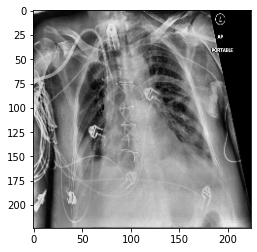

In [56]:
#verifying the agument
for image, label in test_set:
    plt.imshow(image[5].numpy().astype("uint8"))
    plt.show()
    break

In [31]:
# Loop over the images in the dataset and save them to files
def save_to_dir(data, save_path):
    for images, labels in data:
        for i, image in enumerate(images):
            # Define the file path for the image
            image = image.numpy().astype("uint8")
            file_path = f'{save_path}/{i}_{labels[i]}.jpg'
            # Write the image to the file path
            tf.io.write_file(file_path, tf.image.encode_png(image))
            


In [9]:
# save_to_dir(test_set, '/kaggle/working/test/')
# save_to_dir(train_set, '/kaggle/working/train')
# save_to_dir(val_set, '/kaggle/working/val/')


In [11]:
t_label = list()
for image, label in train_set:
    for val in label:
        t_label.append(val)
train_labels = np.asarray(t_label)

from IPython.display import clear_output
clear_output()

In [12]:
from sklearn.utils import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced', classes=[0, 1,2], y=train_labels)

In [14]:
class_weight= [0.63819127, 0.8298697 , 4.38474946]

In [ ]:
#len(train_set[0][1][1])
i= 0
image, label = train_set[i][0], train_set[i][1]
print(image.shape)
print(label.shape)
tb = np.argwhere(test_set[0][1]==2)

In [ ]:
def image_to_plot(data_set):
    tb= list()
    for i in range(len(data_set)):
        image, label = data_set[i][0], data_set[i][1]
        x = np.argwhere(label== 2)
        if (len(x)>0):
            for pos in range(len(x)):
                tb.append([i,int(x[pos])])
        if len(tb)>10:
            break
    return tb
tb_pos = image_to_plot(train_set)

In [ ]:
tb_index = np.asarray(tb_pos)

**Working with resnet50, Importing and freezing the layers and adding own layers**

In [35]:
#agumentation 
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
tf.keras.layers.RandomRotation(0.1),
tf.keras.layers.RandomContrast(factor=0.4),
])

In [16]:
#Importing resnet50,preparing the base convolution 
conv_base = ResNet50(
    weights= 'imagenet',
    include_top = False,
    input_shape = (224, 224,3))
conv_base.trainable = False

94781440/94765736 [==============================] - 4s 0us/step


In [17]:
#Analyzing the base
#save path 
save_path = '/kaggle/working'

#It will take a (224, 224,3 ) image and use diffrent convolutions with skip conncections and will produce a (7, 7, 2048) output

In [18]:
#Preaparing our model 
from keras.layers import BatchNormalization

model_r = Sequential()
model_r.add(tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)))
model_r.add(data_augmentation)
model_r.add(conv_base)
model_r.add(tf.keras.layers.GlobalAveragePooling2D())
model_r.add(Flatten())
model_r.add(BatchNormalization())
model_r.add(Dense(1024, activation='relu'))
# model_r.add(Dropout(0.1))
model_r.add(BatchNormalization())
model_r.add(Dense(256, activation='relu'))
# # # # model_r.add(Dropout(0.2))
model_r.add(BatchNormalization())
model_r.add(Dense(3, activation= 'linear'))

In [ ]:
# #Loading a saved Model 
# model_r = tf.keras.models.load_model('/kaggle/input/trainedresnet/resnet_model_trained_50epochs.h5')
# model_new = tf.keras.Sequential()
# model_new.add(tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)))
# model_new.add(model_r)
# # model_new.add(model_r.layers[0])
# # for i in range(2,len(model_r.layers)):
# #    model_new.add(model_r.layers[i])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 1024)             

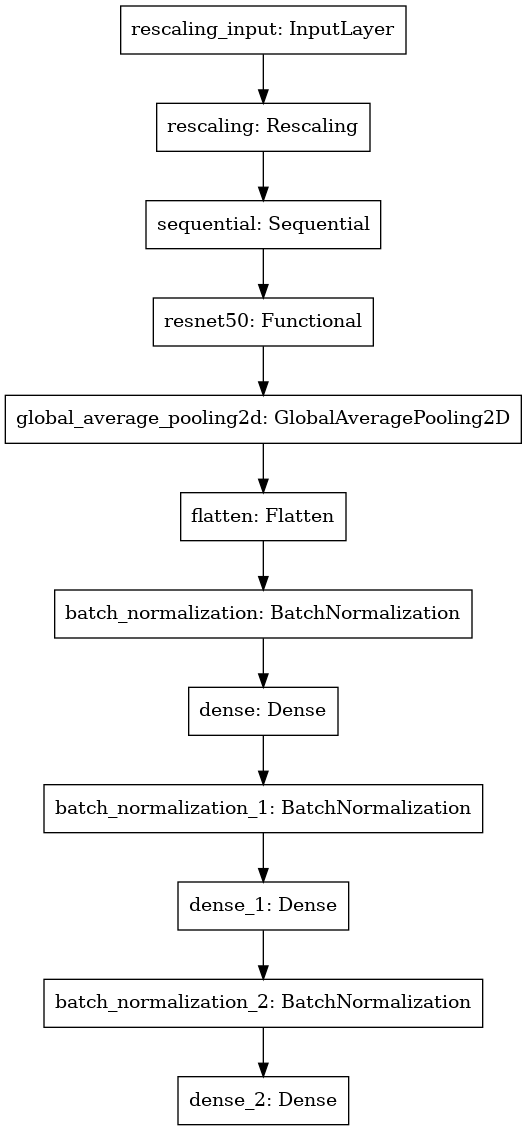

In [19]:
model_r.summary()
tf.keras.utils.plot_model(model_r)

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

call  = [
    EarlyStopping(monitor='val_loss', patience=7, mode='min', min_delta=0.0001),
    ModelCheckpoint(f'{save_path}/resnet_model_train1.h5', monitor='val_loss', save_best_only=True, mode='min')
]

# Instantiate the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_r.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=optimizer,
             metrics=['sparse_categorical_accuracy'],
              )

In [22]:
class_wt = {0:class_weight[0],
           1:class_weight[1],
           2:class_weight [2]}
#Training the Data, training with gpu
with tf.device('/device:GPU:0'):
  history = model_r.fit(train_set, validation_data = val_set,class_weight=class_wt ,
                        epochs =50, callbacks =call)

Epoch 1/50


2023-02-20 09:02:42.241991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


315/315 [==============================] - 111s 317ms/step - loss: 0.6732 - sparse_categorical_accuracy: 0.6972 - val_loss: 1.5788 - val_sparse_categorical_accuracy: 0.1587


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
315/315 [==============================] - 86s 268ms/step - loss: 0.4780 - sparse_categorical_accuracy: 0.7825 - val_loss: 0.6390 - val_sparse_categorical_accuracy: 0.7749
Epoch 3/50
315/315 [==============================] - 84s 263ms/step - loss: 0.4188 - sparse_categorical_accuracy: 0.8081 - val_loss: 0.5228 - val_sparse_categorical_accuracy: 0.8187
Epoch 4/50
315/315 [==============================] - 83s 259ms/step - loss: 0.3554 - sparse_categorical_accuracy: 0.8360 - val_loss: 0.5213 - val_sparse_categorical_accuracy: 0.8055
Epoch 5/50
315/315 [==============================] - 83s 259ms/step - loss: 0.3388 - sparse_categorical_accuracy: 0.8401 - val_loss: 0.4853 - val_sparse_categorical_accuracy: 0.8257
Epoch 6/50
315/315 [==============================] - 91s 284ms/step - loss: 0.2978 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.4635 - val_sparse_categorical_accuracy: 0.8337
Epoch 7/50
315/315 [==============================] - 90s 280ms/step - loss: 0.2836 -

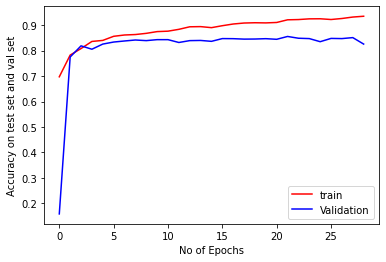

In [25]:
#Plotting Accuracy
import matplotlib.pyplot as plt 
plt.plot(history.history['sparse_categorical_accuracy'], color= 'red', label = 'train')
plt.plot(history.history['val_sparse_categorical_accuracy'], color = 'blue', label = 'Validation')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy on test set and val set')
plt.legend()
plt.show()

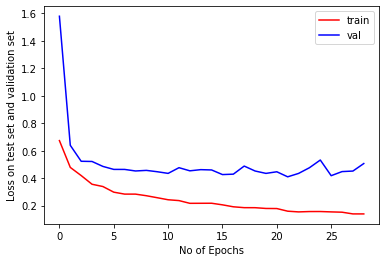

In [26]:
#Plotting Loss
plt.plot(history.history['loss'], color= 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'val')
plt.xlabel('No of Epochs')
plt.ylabel('Loss on test set and validation set')
plt.legend()
plt.show()

In [27]:
#Saving history Parameter for future
import json
history_json = json.dumps(history.history)
# Save the JSON string to a file
with open("resnet_train_1.json", "w") as f:
    f.write(history_json)

In [28]:
tf.keras.models.save_model(model_r,f'{save_path}/resnet_model_final_1.h5')

In [32]:
model_r = tf.keras.models.load_model('/kaggle/working/resnet_model_train1.h5')

# Evaluating performance of trained model on test set

In [29]:
def output_prep(data_set, mod):
    try:
     del original_class, predicted_class, output_prob
    except:
        pass
    #Array of Original Class Labels, shape(test_set_size,)
    original_label = list()
    for image, label in data_set:
        for val in label:
            original_label.append(val)
    original_class = np.asarray(original_label) 
    
    #Array of predicted labels 
    output = mod.predict(test_set) #Calculated probabilities, shape (test_set_size,3)
    
    #Predicting the output class, shape=(test_set_size,)
    predicted_class = np.argmax(output, axis = 1)
    
    return original_class, predicted_class, output



def model_evaluation(original_class, predicted_class):
    conf_mat = metrics.confusion_matrix(original_class, predicted_class, labels= None)
    report = metrics.classification_report(original_class,predicted_class, labels= None)
    normalized_conf_mat = metrics.confusion_matrix(original_class, predicted_class, labels= None, normalize= 'true')
    return conf_mat, normalized_conf_mat, report

def confusion_plot(mat, title ):
    sn.heatmap(mat, cmap= 'Greens', annot =True, xticklabels= ['Normal', 'Pnemo', 'Tb'], yticklabels= ['Normal', 'Pnemo', 'Tb'])
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(title)
    plt.show()

Confusion Matrix:
 [[647  88  17]
 [ 85 490   3]
 [  9   1 101]] 


 Classification Report:

               precision    recall  f1-score   support

           0       0.87      0.86      0.87       752
           1       0.85      0.85      0.85       578
           2       0.83      0.91      0.87       111

    accuracy                           0.86      1441
   macro avg       0.85      0.87      0.86      1441
weighted avg       0.86      0.86      0.86      1441



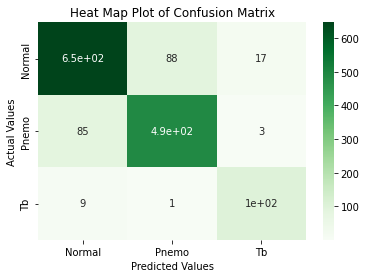

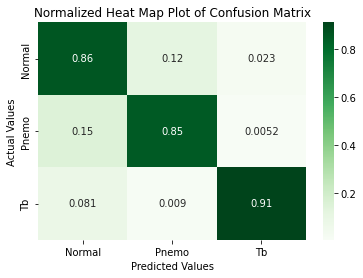

In [33]:
original_class, predicted_class, output_prob = output_prep(test_set,model_r)
conf_mat, normalized_conf_mat, report = model_evaluation(original_class, predicted_class)
print("Confusion Matrix:\n", conf_mat,"\n\n\n", "Classification Report:\n\n", report)
confusion_plot(conf_mat, "Heat Map Plot of Confusion Matrix")
confusion_plot(normalized_conf_mat, "Normalized Heat Map Plot of Confusion Matrix")

#Incpetion V3 training

In [ ]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam 

base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape = (224, 224, 3)
    
)

base_model.trainable = False

In [ ]:
model_i = tf.keras.Sequential()
model_i.add(tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)))
model_i.add(data_augmentation)
model_i.add(base_model)
model_i.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(keras.layers.Dropout(0.2))
model_i.add(Flatten())
model_i.add(tf.keras.layers.BatchNormalization())
model_i.add(tf.keras.layers.Dense(1024, activation="relu"))
model_i.add(tf.keras.layers.BatchNormalization())
model_i.add(tf.keras.layers.Dense(256, activation="relu"))
model_i.add(tf.keras.layers.BatchNormalization())
model_i.add(tf.keras.layers.Dense(3, activation="linear"))

In [ ]:
model_i.summary()

In [ ]:
#Training the Data, training with gpu
from keras.callbacks import EarlyStopping, ModelCheckpoint
call2  = [
    EarlyStopping(monitor='val_loss', patience=7, mode='min', min_delta=0.0001),
    ModelCheckpoint('inception_training_1.h5', monitor='val_loss', save_best_only=True, mode='min')
]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_i.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=optimizer,
             metrics=['sparse_categorical_accuracy'],
              )

In [ ]:
model_i = tf.keras.models.load_model('/kaggle/working/inception_training.h5')

In [ ]:
#Training the Data, training with gpu
with tf.device('/device:GPU:0'):
  history_i = model_i.fit(train_set, validation_data = val_set,
                        class_weight = class_wt, epochs =50, 
                        callbacks =call2,
                       verbose = 1)

In [ ]:
#Plotting Accuracy
import matplotlib.pyplot as plt 
plt.plot(history.history['sparse_categorical_accuracy'], color= 'red', label = 'train')
plt.plot(history.history['val_sparse_categorical_accuracy'], color = 'blue', label = 'Validation')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy on test set and val set')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [ ]:
plt.plot(history_i.history['loss'], color= 'red', label = 'train')
plt.plot(history_i.history['val_loss'], color = 'blue', label = 'val loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss on Validation Set set')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
#Saving history Parameter for future
import json
history_json = json.dumps(history_i.history)
# Save the JSON string to a file
with open("resnet_train_1.json", "w") as f:
    f.write(history_json)

In [ ]:
tf.keras.models.save_model(model_i,'inception_model-train2.h5')

In [ ]:
import matplotlib.pyplot as plt 
def model_plot(history):
    #Accuracy Plot
    plt.plot(history.history['sparse_categorical_accuracy'], color= 'red', label = 'train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], color = 'blue', label = 'Validation')
    plt.xlabel('No of Epochs')
    plt.ylabel('Accuracy on test set and val set')
    plt.legend()
    plt.title('Model Accuracy')
    plt.show()
    
    #Loss Plot
    plt.plot(history.history['loss'], color= 'red', label = 'train')
    plt.plot(history.history['val_loss'], color = 'blue', label = 'train')
    plt.xlabel('No of Epochs')
    plt.ylabel('Loss on Validation Set set')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

**Inception Model Evaluation**

In [ ]:
original_class, predicted_class, output_prob = output_prep(test_set,model_i)
conf_mat, normalized_conf_mat, report = model_evaluation(original_class, predicted_class)
print("Confusion Matrix:\n", conf_mat,"\n\n\n", "Classification Report:\n\n", report)
confusion_plot(conf_mat, "Heat Map Plot of Confusion Matrix")
confusion_plot(normalized_conf_mat, "Normalized Heat Map Plot of Confusion Matrix")